In [1]:
import numpy as np
from scipy import signal
from scipy import fftpack
from matplotlib import pyplot as plt
from crawlab_toolbox import plotting

In [2]:
def create_noisy_signal(
    numPoints, samplingRate, frequencies, amplitudes,
    noiseStDev, phase=0, offset=0,
    frequencyError=0.05, harmonics=1,
    saveSignal=False,fileName='signal'):
    '''
    create_noisy_signal

    Create a signal with desired randomness and spectral qualities.

    Inputs:
        - duration: time (in seconds) captured by the signal
        - samplingRate: rate (in Hz) of the signal
        - frequencies: list of frequencies in the signal
        - amplitudes: amplitudes of the corresponding frequencies
        - (float) noiseStDev: standard deviation squared) of
                the gaussian noise added to the signal
        - (float) frequencyStDev: standard deviation
                of the gaussian noise added to the frequency
        - (float) amplitudeStDev: standard deviation
                of the gaussian noise added to the amplitudes
        - (float) phaseStDev: StDev (standard deviation squared) of
                the gaussian noise added to the phase of the signal

    '''

    # determine the required number of datapoints to cover the duration
    # at the required sampling rate
#     numPoints = int(duration * samplingRate)

    # Create a time array with the correct start and endpoint, sampled at
    # the required sampling rates
#     time = np.atleast_2d(np.linspace(0,duration,numPoints))
    time = np.atleast_2d(np.cumsum(np.ones(numPoints) / samplingRate))

    # Ensure that all of the inputs are cast as numpy arrays
    freqs = np.atleast_2d(np.asarray(frequencies).flatten()).T
    amps = np.atleast_2d(np.asarray(amplitudes).flatten()).T
    noiseStDev = np.asarray(noiseStDev)

    # Modify the signal slightly
    m, n = freqs.shape
#     phase = np.atleast_2d(phaseStDev * np.random.random((m, n)))

    # Create randomly distributed noise with a given standard deviation
    noise = noiseStDev * np.random.random(numPoints)

    # The number of input frequencies must be identical to the number
    # of input amplitudes
    if len(freqs) != len(amps):
        raise ValueError('Length of input frequencies must be identical to\
                          that of input amplitudes')

    signal = np.sum(amps * np.sin(2 * np.pi * freqs * time + phase), axis=0) + noise + offset

    if saveSignal:
        fName = fileName + '.txt'
        timeName = fileName + '_time.txt'
        np.savetxt(fName, np.round(signal,6), header='Signal', delimiter=',')
        np.savetxt(timeName, np.round(time,6), header='Time (s)', delimiter=',')

    return time.flatten(), signal

In [3]:
numPoints = 256
samplingRate = 1024
thisFreq = [64,]
thisAmp = [1]
thisNoise = 0.
offset = 0.


In [4]:
timeSampled,mySignal = create_noisy_signal(numPoints,samplingRate,thisFreq,thisAmp,thisNoise,offset=offset)
timeSampled_odd,mySignal_odd = create_noisy_signal(int(numPoints*0.95),samplingRate,thisFreq,thisAmp,thisNoise,offset=offset,phase=np.pi/7)

time,trueSignal = create_noisy_signal(numPoints*50,samplingRate*50,thisFreq,thisAmp,thisNoise,offset=offset)

sampledSignal = np.interp(time, timeSampled, mySignal, left=None, right=None, period=None)

In [5]:
raw_fft = fftpack.fft(mySignal)
fullSignal_odd = np.zeros(mySignal.shape)
fullSignal_odd[:mySignal_odd.shape[0]] = mySignal_odd

fullSignal_offset = np.zeros(mySignal.shape)
fullSignal_offset[:mySignal_odd.shape[0]] = mySignal_odd + 1.

raw_fft_odd = fftpack.fft(fullSignal_odd)
raw_fft_offset = fftpack.fft(fullSignal_offset)
raw_fft_odd_hanning = fftpack.fft(fullSignal_odd * np.hanning(fullSignal_odd.shape[0]))
print(raw_fft.shape)
print(raw_fft_odd.shape)

(256,)
(256,)


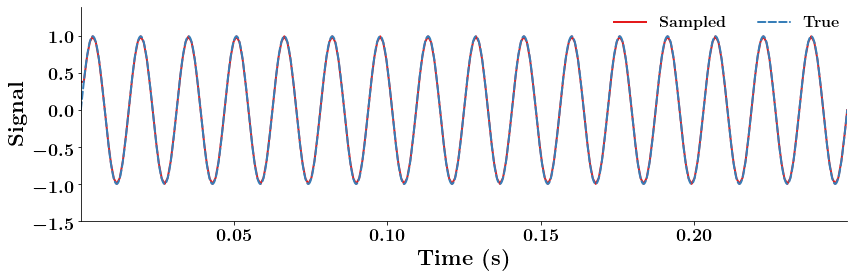

In [7]:

# responses = np.vstack((raw_fft.real,raw_fft.imag,(raw_fft * raw_fft.conj()).real))
responses = np.vstack((sampledSignal,trueSignal))
plotting.generate_plot(time,responses,
                         ['Sampled','True'],'Time (s)','Signal',showplot=True,
                         template='wide',
                         ymax=0.2,
                         save_plot=True,
                         transparent=True,
                         num_col=2,
                         folder='Figures/FFT_Example',
                         filename='raw_Signal_3',
                         file_type='png')



(2, 128)


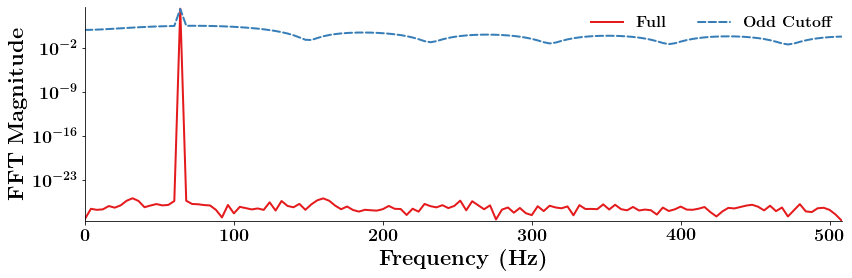

(256,)
(256,)
(2, 127)


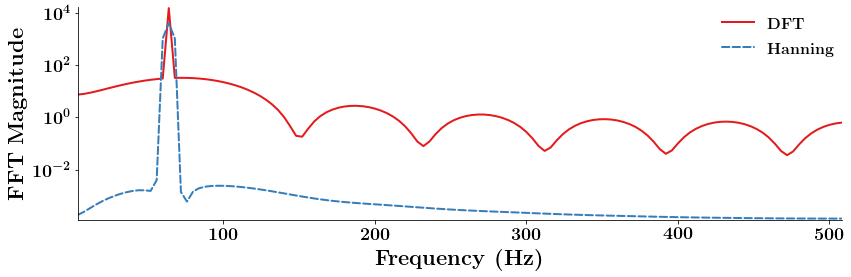

In [8]:

freq = np.fft.fftfreq(mySignal.shape[0]) * samplingRate
freq_odd = np.fft.fftfreq(mySignal_odd.shape[0]) * samplingRate


# raw_fft = np.interp(freq_odd, freq, raw_fft, left=None, right=None, period=None)


even_fft = ((raw_fft * raw_fft.conj()).real)[:int(np.ceil(raw_fft.shape[0] / 2))]
odd_fft = ((raw_fft_odd * raw_fft_odd.conj()).real)[:int(np.ceil(raw_fft_odd.shape[0] / 2))]
responses = np.vstack((even_fft,odd_fft))

print(responses.shape)
plotting.generate_plot(freq[:int(np.ceil(raw_fft.shape[0] / 2))],responses,
                         ['Full','Odd Cutoff'],'Frequency (Hz)','FFT Magnitude',showplot=True,
                         template='wide',
                         save_plot=True,
                         transparent=True,
                         ymax = 1,
                         num_col=2,
                         log_y=True,
                         folder='Figures/FFT_Example',
                         filename='Raw_FFT_Physical_Leakage',
                         file_type='png')


freq= np.fft.fftfreq(fullSignal_odd.shape[0]) * samplingRate
odd_fft = (raw_fft_odd * raw_fft_odd.conj()).real
odd_fft_hanning = (raw_fft_odd_hanning * raw_fft_odd_hanning.conj()).real

print(odd_fft.shape)
print(odd_fft_hanning.shape)
responses = np.vstack((odd_fft,odd_fft_hanning))[:,1:int(np.ceil(raw_fft_odd.shape[0] / 2))]

print(responses.shape)
plotting.generate_plot(freq[1:int(np.ceil(raw_fft_odd.shape[0] / 2))],responses,
                         ['DFT','Hanning'],'Frequency (Hz)','FFT Magnitude',showplot=True,
                         template='wide',
                         save_plot=True,
                         transparent=True,
                         num_col=1,
                         log_y=True,
                         folder='Figures/FFT_Example',
                         filename='Raw_FFT_Physical_Window',
                         file_type='png')


In [32]:
numPoints = 128

hamming_window = signal.windows.hamming(numPoints)
hanning_window = signal.windows.hann(numPoints)
rectangular_window = np.zeros(numPoints)
rectangular_window[1:-1] = np.ones(numPoints - 2)
blackman_window = signal.windows.blackman(numPoints)


In [41]:
hamming_fft = fftpack.fft(hamming_window)
hamming_fft = (hamming_fft * hamming_fft.conj()).real
hamming_fft = np.roll(hamming_fft,int(numPoints / 2))


hanning_fft = fftpack.fft(hanning_window)
hanning_fft = (hanning_fft * hanning_fft.conj()).real
hanning_fft = np.roll(hanning_fft,int(numPoints / 2))

rectangular_fft = fftpack.fft(rectangular_window)
rectangular_fft = (rectangular_fft * rectangular_fft.conj()).real
rectangular_fft = np.roll(rectangular_fft,int(numPoints / 2))


blackman_fft = fftpack.fft(blackman_window)
blackman_fft = (blackman_fft * blackman_fft.conj()).real
blackman_fft = np.roll(blackman_fft,int(numPoints / 2))


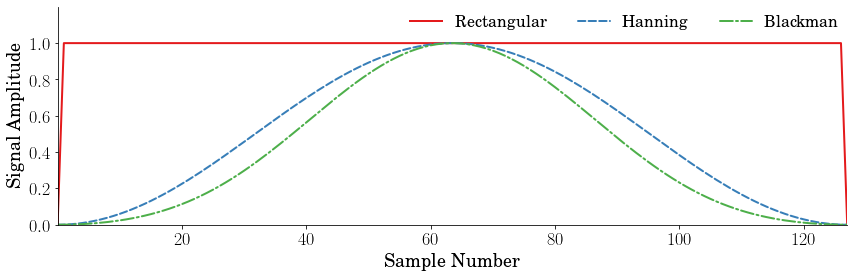

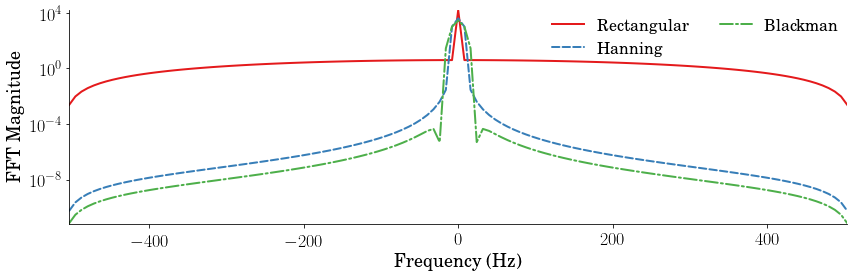

In [54]:
responses = np.vstack((rectangular_window,hanning_window,blackman_window))
time = np.cumsum(np.ones(numPoints) / samplingRate)

plotting.generate_plot(np.arange(numPoints),responses,
                         ['Rectangular','Hanning','Blackman'],'Sample Number','Signal Amplitude',showplot=True,
                         template='wide',
                         save_plot=True,
                         transparent=True,
                         ymax=0.2,
                         num_col=3,
                         log_y=False,
                         folder='Figures/FFT_Example',
                         filename='Signal_Window_Comparison',
                         file_type='png')


responses = np.vstack((rectangular_fft,hanning_fft,blackman_fft))
freq= np.fft.fftfreq(numPoints) * samplingRate

plotting.generate_plot(np.sort(freq)[1:],responses[:,1:],
                         ['Rectangular','Hanning','Blackman'],'Frequency (Hz)','FFT Magnitude',showplot=True,
                         template='wide',
                         save_plot=True,
                         transparent=True,
                         num_col=2,
                         log_y=True,
                         folder='Figures/FFT_Example',
                         filename='FFT_Window_Comparison',
                         file_type='png')